# PCA
Principal Component Analysis (PCA) is a technique that reorganizes data along orthogonal axes (principal components (PC)) from most to least significant, preserving as much variance as possible.

As a side effect it is often used to reduce dimensionality (1) reorganize data on a new set of axes from most to least significant (2) throw away everything above a threshold of variance, or above N-dimensions. Here we will use it to throw away most of the dimensions of embeddings vectors so we can plot them on a 2D graph.

## Building some intuition
Rough outline:
1) scale the data so each dimensions is in the same range
2) center the data on 0 (shift all the values around the `mean()`)
3) fit a line from the origin `(0, 0)` through the data that minimize the squared sum of the projections (of our datapoints into said line)
4) create a perpendicular axis to it following the same properties until all dimensions are covered

Note: Steps (1) and (2) combined are equivalent to normalizing each axis to a Gaussian. Which reminds me of the [BatchNorm from the Karpathy's course](https://youtu.be/P6sfmUTpUmc?t=2454)

In [3]:
import torch
import math
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

%matplotlib inline

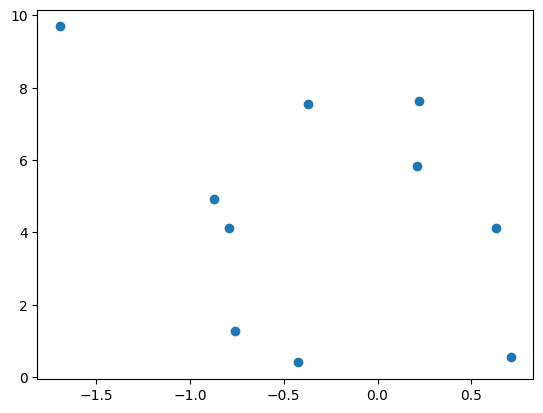

In [4]:
# imagine a dataset 2 dimensional embeddings (x, y)
x = torch.randn(20).view(-1, 2)
x[:, 1] = x[:, 1] * 3 + 3
plt.scatter(x[:, 0], x[:, 1])

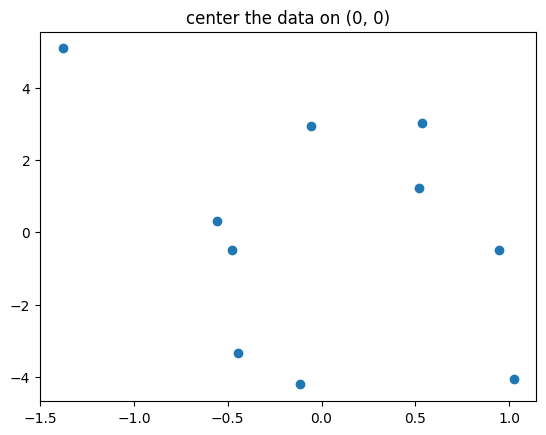

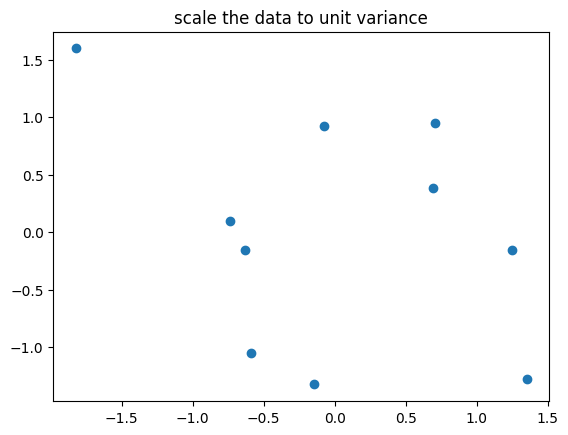

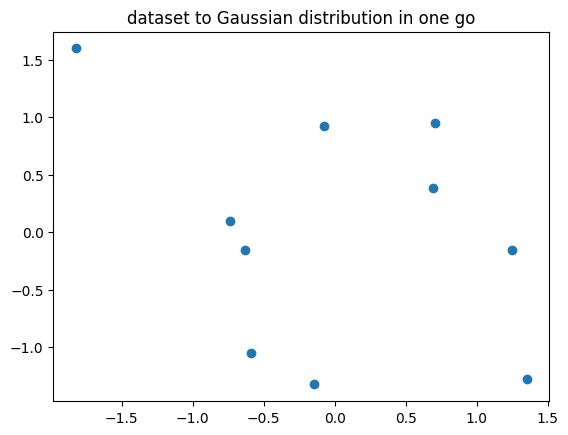

In [5]:
# normalize the data to a Gaussian distribution step by step
xx = x.clone()

# step 1: center the data on to (0, 0)
xx -= xx.mean(0, keepdim=True)
plt.scatter(xx[:, 0], xx[:, 1])
plt.title('center the data on (0, 0)')
plt.show()

# step 2: scale the data to unit variance
xx /= (1e-8 + xx.std(0, keepdim=True)) # adding an epsilon to avoid dividing by zero
plt.scatter(xx[:, 0], xx[:, 1])
plt.title('scale the data to unit variance')
plt.show()

# step 1 + 2: center and scale the data
normalized_x = (x - x.mean(0, keepdim=True)) / (1e-8 + x.std(0, keepdim=True)) # adding an epsilon to avoid dividing by zero
plt.scatter(normalized_x[:, 0], normalized_x[:, 1])
plt.title('dataset to Gaussian distribution in one go')
plt.show()

In [6]:
# just a helper to plot a line that fit nicely in the plot
def plot_line(plt, angle):
    ar = math.radians(angle)
    v = torch.tensor([math.cos(ar), math.sin(ar)])
    x_min, x_max, y_min, y_max = plt.axis()
    diag = torch.tensor([x_max - x_min, y_max - y_min]).norm()
    v *= diag / 2.
    plt.plot([-v[0], v[0]], [-v[1], v[1]], linestyle='--', color='red', label=f'Angle: {angle}°')

angle 49° minimizes the sum of squared distances: 1.8907197713851929


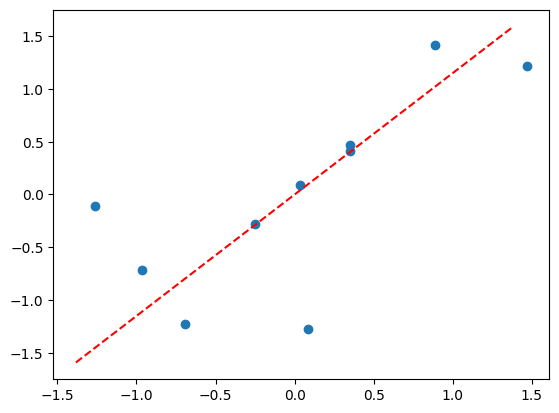

In [7]:
# fit a line through the data (re-run the cell to get more examples)
x = torch.randn(20).view(-1, 2)
normalized_x = (x - x.mean(0, keepdim=True))
mini = float('inf')
best_angle = 0

# /!\ this is for demo purpose only
# iterate over all (~not really but shush~)
for i in range(0, 180):
    sum_of_squared_distances = 0
    angle = math.radians(i)
    slope = torch.tensor([math.cos(angle), math.sin(angle)])
    for point in normalized_x:
        projection = (point.dot(slope) / slope.dot(slope)) * slope
        squared_distance = (point - projection).pow(2).sum()
        sum_of_squared_distances += squared_distance
    if sum_of_squared_distances < mini:
        mini = sum_of_squared_distances
        best_angle = i

print(f'angle {best_angle}° minimizes the sum of squared distances: {mini}')
plt.scatter(normalized_x[:, 0], normalized_x[:, 1])
plot_line(plt, best_angle)
plt.show()

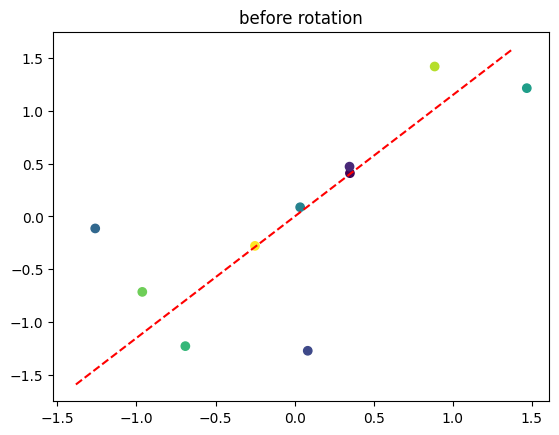

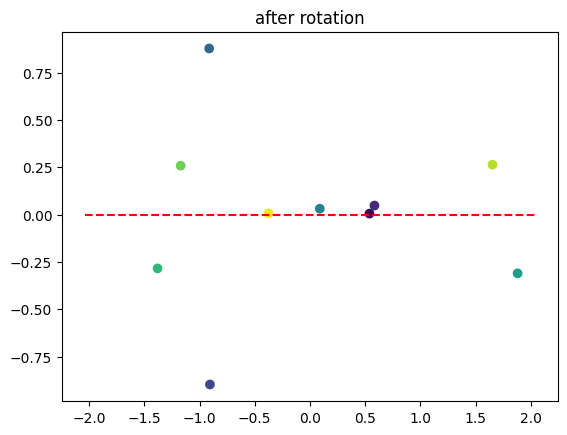

In [8]:
# rotate the world so the line is horizontal (becomes your new X-axis)
colors = torch.arange(len(normalized_x))

plt.scatter(normalized_x[:, 0], normalized_x[:, 1], c=colors, cmap='viridis')
plot_line(plt, best_angle)
plt.title('before rotation')
plt.show()

angle = math.radians(best_angle)
rotation_matrix = torch.tensor([[math.cos(angle), -math.sin(angle)], [math.sin(angle), math.cos(angle)]])
rotated_x = torch.zeros_like(normalized_x)
for i, point in enumerate(normalized_x):
    rotated_x[i] = rotation_matrix.T @ point

plt.scatter(rotated_x[:, 0], rotated_x[:, 1], c=colors, cmap='viridis')
plot_line(plt, 0)
plt.title('after rotation')
plt.show()

In [43]:
def rotate(data, angle):
    angle = math.radians(angle)
    rotation_matrix = torch.tensor([[math.cos(angle), -math.sin(angle)], [math.sin(angle), math.cos(angle)]])
    rotated = torch.zeros_like(data)
    for i, point in enumerate(data):
        rotated[i] = rotation_matrix.T @ point
    return rotated

def plot_step(ax, data, angle):
    ax.scatter(data[:, 0], data[:, 1], c=colors, cmap='viridis')
    plot_line(ax, angle)

def get_scale(data, angle, delta=0.1):
    xs = [*data[:, 0].tolist()]
    ys = [*data[:, 1].tolist()]
    for i in range(angle + 1):
        rotated = rotate(data, angle)
        xs.extend(rotated[:, 0].tolist())
        ys.extend(rotated[:, 1].tolist())
    return min(xs) - delta, max(xs) + delta, min(ys) - delta, max(ys) + delta

def get_frame(ax, data, angle):
    min_x, max_x, min_y, max_y = get_scale(data, angle)    
    def f(step):
        ax.clear()
        ax.set_xlim(min_x, max_x)
        ax.set_ylim(min_y, max_y)
        rotated = rotate(data, step)
        plot_step(ax, rotated, angle - step)
    return f

def animate_pca(data, angle, figsize=(5, 5)):
    fig, ax = plt.subplots(figsize=figsize)
    ani = FuncAnimation(fig, get_frame(ax, data, angle), frames=angle + 1, interval=50, repeat=False)
    plt.close()
    return ani

ani = animate_pca(normalized_x, best_angle)
display(HTML(ani.to_jshtml()))

## Using the real deal

In [10]:
from sklearn.decomposition import PCA

### Compute the principal components

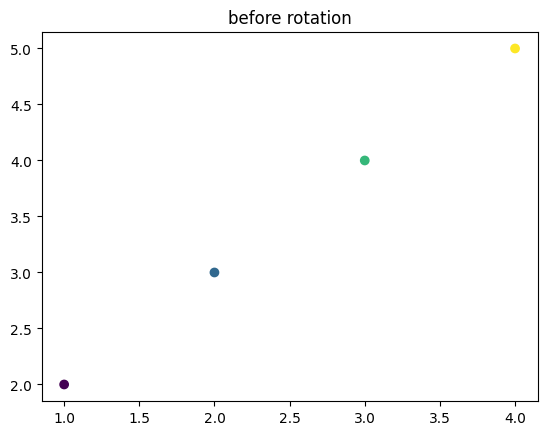

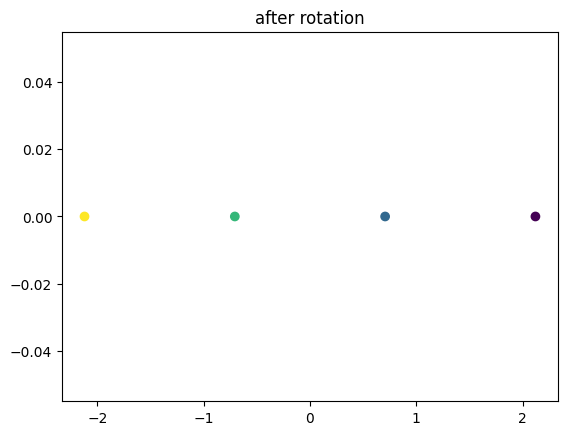

In [11]:
data = torch.tensor([[1, 2], [2, 3], [3, 4], [4, 5]]).float()
colors = torch.arange(len(data))

pca = PCA(n_components=data.shape[1])
principal_components = pca.fit_transform(data)

plt.scatter(data[:, 0], data[:, 1], c=colors, cmap='viridis')
plt.title('before rotation')
plt.show()

plt.scatter(principal_components[:, 0], principal_components[:, 1], c=colors, cmap='viridis')
plt.title('after rotation')
plt.show()

### Use PCA to reduce the dimensionality of the data

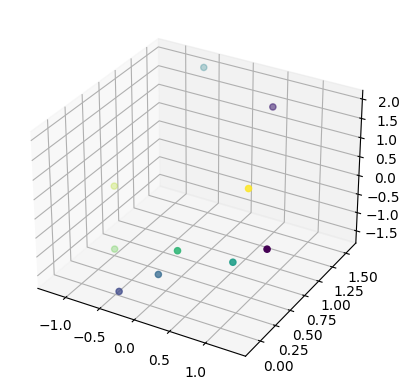

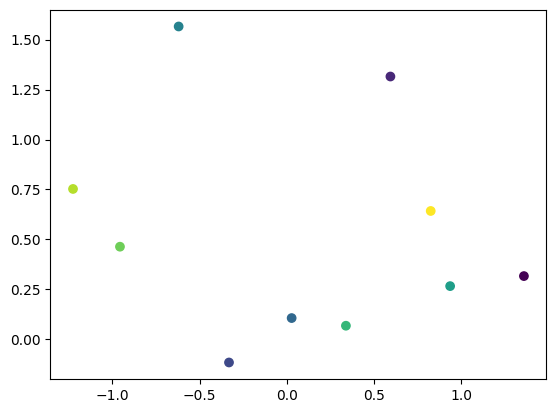

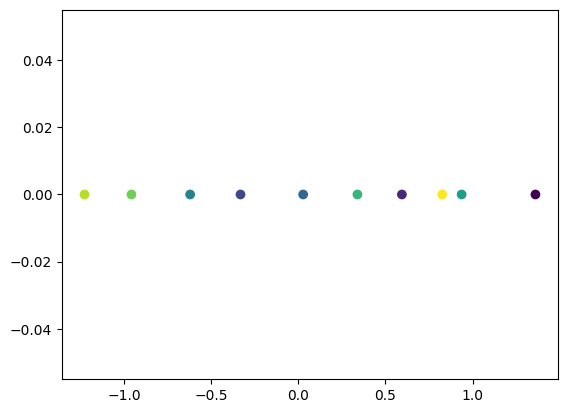

In [12]:
data = torch.randn(3 * 10).view(-1, 3)
colors = torch.arange(len(data))

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(data[:, 0], data[:, 1], data[:, 2], c=colors, cmap='viridis')
plt.show()

pca = PCA(n_components=2)
principal_components = pca.fit_transform(data)
plt.scatter(data[:, 0], data[:, 1], c=colors, cmap='viridis')
plt.show()

pca = PCA(n_components=1)
principal_components = pca.fit_transform(data)
plt.scatter(data[:, 0], torch.zeros_like(data[:, 0]), c=colors, cmap='viridis')
plt.show()

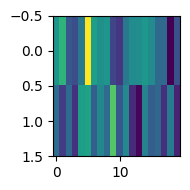

In [13]:
embedding_matrix = torch.randn(2 * 20).view(-1, 20)

plt.figure(figsize=(2, 2))
plt.imshow(embedding_matrix, cmap='viridis', aspect='auto')
plt.tight_layout()
plt.show()